# Definição do problema

Objetivos:

1. Prever a avaliação que um usuário daria a um filme que ainda não avaliou. 
2. Minimizar a diferença entre avaliação prevista e real ( RMSE e MAPE).

## Fonte de dados

A netflix forneceu muitos dados de classificação anonimos e uma barra de precisao de predição que é 10% melhor do que o que o Cinematch pode fazer no mesmo conjunto de dados de treinamento. A precisão é uma medida de quão proximos as classificações previstas dos filmes correspondem as classificações subsequentes. 

https://www.kaggle.com/datasets/netflix-inc/netflix-prize-data

In [1]:
#Imports
import os 
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import scipy
import sklearn
from scipy import sparse
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
from datetime import datetime

# formatação dos gráficos
matplotlib.use('nbagg')
plt.rcParams.update({'figure.max_open_warning': 0})
sns.set_style('whitegrid')

In [4]:
# Versões dos pacotes
%reload_ext watermark
%watermark -a 'Rodrigo Sabino' --iversions

Author: Rodrigo Sabino

matplotlib: 3.7.2
scipy     : 1.10.0
seaborn   : 0.12.2
sklearn   : 1.2.1
numpy     : 1.24.3
pandas    : 1.5.3



## Carregando os dados 

Para carregar os dados vamos executar as seguintes operações: 

* 1- Fazer a leitura das linhas de todos os arquivos disponíveis. 
* 2- Combinar todas as linhas de todos os arquivos em um único arquivo. 
* 3- Carregar op arquivo gerado em um dataframe do pandas. 


In [14]:
# Marcar o inicio da execução 
start = datetime.now()

In [15]:
# Criaremos um arquivo final chamado dados.csv

# Se o arquivo não existir, criamos o arquivo em modo de escrita (w)
if not os.path.isfile('data/dados_netflix/dados.csv'):
    dataset = open('data/dados_netflix/dados.csv', mode='w')
    linhas = list()
    arquivos = ['data/dados_netflix/combined_data_1.txt',
                'data/dados_netflix/combined_data_2.txt',
                'data/dados_netflix/combined_data_3.txt',
                'data/dados_netflix/combined_data_4.txt']
    
    for arquivo in arquivos:
        print("Lendo o arquivo{}...".format(arquivo))
        
        with open(arquivo) as f:
            for linha in f:
                linha = linha.strip()
                if linha.endswith(':'):
                    movie_id = linha.replace(':', '')
                else:
                    linhas = [x for x in linha.split(',')]
                    linhas.insert(0, movie_id)
                    dataset.write(','.join(linhas))
                    dataset.write('\n')
        print('Concluido.\n')
    dataset.close()

Lendo o arquivodata/dados_netflix/combined_data_1.txt...
Concluido.

Lendo o arquivodata/dados_netflix/combined_data_2.txt...
Concluido.

Lendo o arquivodata/dados_netflix/combined_data_3.txt...
Concluido.

Lendo o arquivodata/dados_netflix/combined_data_4.txt...
Concluido.



In [16]:
print('Tempo total para carregar os arquivos:', datetime.now() - start)

Tempo total para carregar os arquivos: 0:02:18.878668


In [17]:
# Carregando o arquivo concolidado dados no dataframe pandas. 
df_netflix = pd.read_csv('data/dados_netflix/dados.csv', sep = ',', names= ['movie', 'user', 'rating', 'date'])
df_netflix.date = pd.to_datetime(df_netflix.date)
print('concluido')

concluido


In [18]:
# Ordenando o dataframe por data
print('Ordenando o dataframe por data')
df_netflix.sort_values(by='date', inplace = True)
print('concluido')

Ordenando o dataframe por data
concluido


In [19]:
#Shape
df_netflix.shape

(100480507, 4)

In [20]:
# Vizualizando os dados
df_netflix.head()

,movie,user,rating,date
56431994,10341,510180,4,1999-11-11
9056171,1798,510180,5,1999-11-11
58698779,10774,510180,3,1999-11-11
48101611,8651,510180,2,1999-11-11
81893208,14660,510180,2,1999-11-11


## Análise Exploratória

In [22]:
# Resumo dos dados
print('Resumo dos dados')
print('-'*50)
print('Número Total de Filmes:', len(np.unique(df_netflix.movie)))
print('Número Total de usuários:', len(np.unique(df_netflix.user)))
print('Número total de Avaliações:', df_netflix.shape[0])

Resumo dos dados
--------------------------------------------------
Número Total de Filmes: 17770
Número Total de usuários: 480189
Número total de Avaliações: 100480507


In [23]:
# Verificando a média das avaliações
df_netflix.describe()['rating']

count    1.004805e+08
mean     3.604290e+00
std      1.085219e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

In [24]:
# Verificando se temos valores ausentes
sum(df_netflix.isnull().any())

0

In [25]:
# Verificando se temos valores duplicados
sum(df_netflix.duplicated(['movie', 'user', 'rating']))

0

Vamos dividir os dados em treino e teste, pois algumas análise só fazem sentido para os dados de treino. Usaremos a proporção 80/20 para treino/testes. 

In [26]:
# Criando um dataset em disco com os dados de treino
if not os.path.isfile('data/dados_netflix/dados_treino.csv'):
    df_netflix.iloc[:int(df_netflix.shape[0]*0.80)].to_csv('data/dados_netflix/dados_treino.csv', index = False)

In [27]:
# Criando um dataset em disco com os dados de teste
if not os.path.isfile('data/dados_netflix/dados_teste.csv'):
    df_netflix.iloc[int(df_netflix.shape[0]*0.80):].to_csv('data/dados_netflix/dados_teste.csv', index = False)

In [28]:
# Deletando o dataframe original para liberar memória
del df_netflix

In [29]:
# Agora carregamos os arquivos em dataframes do pandas
df_netflix_treino = pd.read_csv('data/dados_netflix/dados_treino.csv', parse_dates = ['date'])
df_netlix_teste = pd.read_csv('data/dados_netflix/dados_teste.csv')

Verificando a distribuição da variável de avaliações rating. A função abaixo vai ajustar as medidas em milhares, milhoes e bilhoes para facilitar a leitura dos gráficos

In [30]:
# Função para ajutes das unidades de medida
def ajusta_unidades(num, units = 'M'):
    units = units.lower()
    num = float(num)
    if units == 'k':
        return str(num/10**3) + ' K'
    elif units == 'm':
        return str(num/10**6) + ' M'
    elif units == 'b':
        return str(num/10**9) + ' B'

In [33]:
# Superss warnings
import sys
import warnings 
if not sys.warnoptions:
    warnings.simplefilter('ignore')

<IPython.core.display.Javascript object>


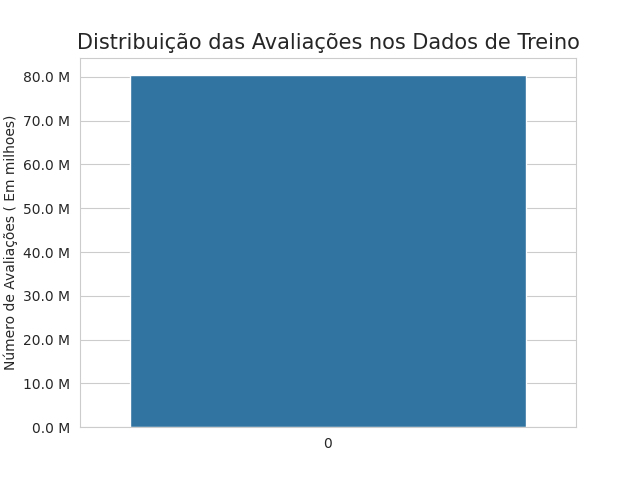

In [34]:
#plot distribuição
fig, ax = plt.subplots()
plt.title('Distribuição das Avaliações nos Dados de Treino', fontsize = 15)
sns.countplot(df_netflix_treino.rating)
ax.set_yticklabels([ajusta_unidades(item, 'M') for item in ax.get_yticks()])
ax.set_ylabel('Número de Avaliações ( Em milhoes)')
plt.show()